# Homework Solution: 뉴스 텍스트 단어 빈도 분석

`homework_solution.py` 스크립트를 주피터 노트북 형식으로 옮겨, 분석 단계와 결과를 한 번에 확인할 수 있도록 정리했습니다.

- 텍스트 정규화 → 명사 추출 → 불용어 제거 → 빈도 계산
- 상위 단어 20개를 막대그래프와 워드클라우드로 시각화
- Windows에서도 바로 실행할 수 있도록 글꼴 검색 순서를 포함

In [1]:
# 핵심 라이브러리를 불러오고 형태소 분석기를 준비합니다.
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import font_manager
from wordcloud import WordCloud

try:
    from konlpy.tag import Okt  # type: ignore
    tokenizer = Okt()
    USING_KONLPY = True
except ImportError:
    class _FallbackOkt:
        """konlpy가 없다면 연속된 한글 문자열만 명사로 취급하는 간단한 대체 분석기입니다."""

        def nouns(self, text: str):
            return re.findall(r"[가-힣]+", text)

    tokenizer = _FallbackOkt()
    USING_KONLPY = False


## 1. 뉴스 텍스트 전처리 및 단어 빈도 계산
`news.txt`를 읽어 불필요한 기호를 정리하고, 명사만 골라 사용자 정의 불용어를 제외한 뒤 빈도를 계산합니다.

In [2]:
# 원문을 읽고 정규화 함수로 깨끗한 텍스트를 만든 뒤 명사 중심으로 토큰화합니다.
DATA_DIR = Path(".")
NEWS_PATH = DATA_DIR / "news.txt"

raw_text = NEWS_PATH.read_text(encoding="utf-8")

def normalize(text: str) -> str:
    """한글과 숫자만 남기고 연속된 공백을 하나로 줄입니다."""
    text = re.sub(r"[^가-힣0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# 분석 목적과 무관한 단어는 불용어로 정의해 제거합니다.
custom_stopwords = {"위해", "위한", "이번", "관련", "수", "등", "및", "통해"}

clean_text = normalize(raw_text)

nouns = []  # 의미가 약한 한 글자 토큰은 제외합니다.
for token in tokenizer.nouns(clean_text):
    if len(token) > 1:
        nouns.append(token)

filtered = []  # 사용자 불용어를 제외한 토큰만 남깁니다.
for token in nouns:
    if token not in custom_stopwords:
        filtered.append(token)

freqs = Counter(filtered)
top_words = freqs.most_common(20)
freq_df = pd.DataFrame(top_words, columns=["word", "count"])

print(f"konlpy 사용 여부: {USING_KONLPY}")
freq_df.head(10)


konlpy 사용 여부: True


word  count
0   공원     19
1   녹지     19
2   계획     16
3   도시      9
4  서울시      6
5   기후      5
6   대응      5
7   기능      4
8   목표      4
9   확충      4

## 2. 시각화: 막대그래프와 워드클라우드
한글 폰트를 자동으로 탐색한 뒤, 상위 단어를 막대그래프와 워드클라우드로 시각화합니다.

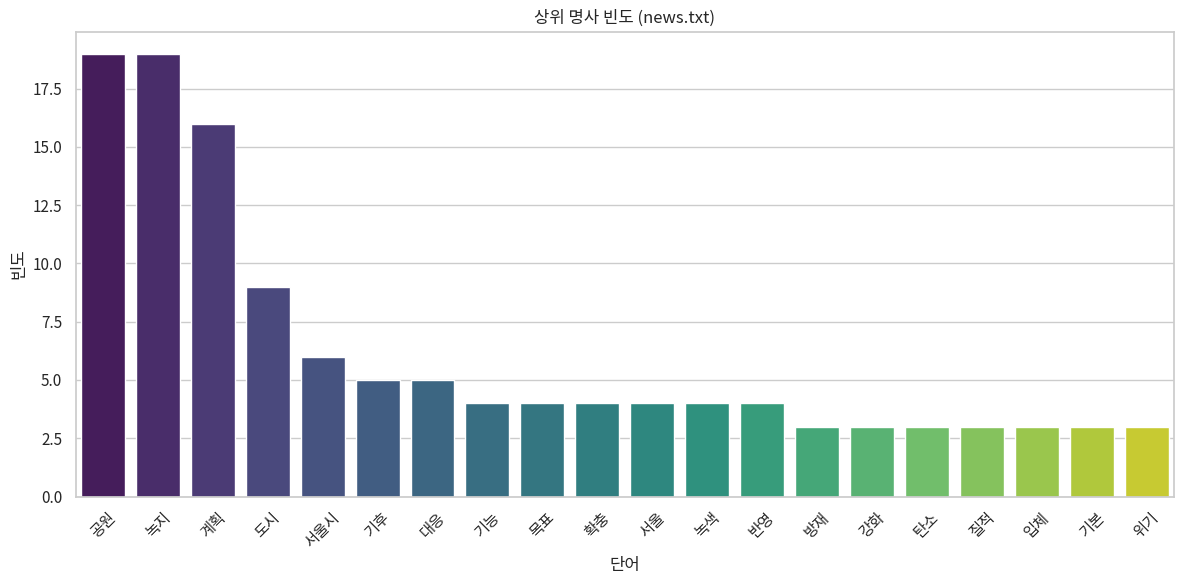

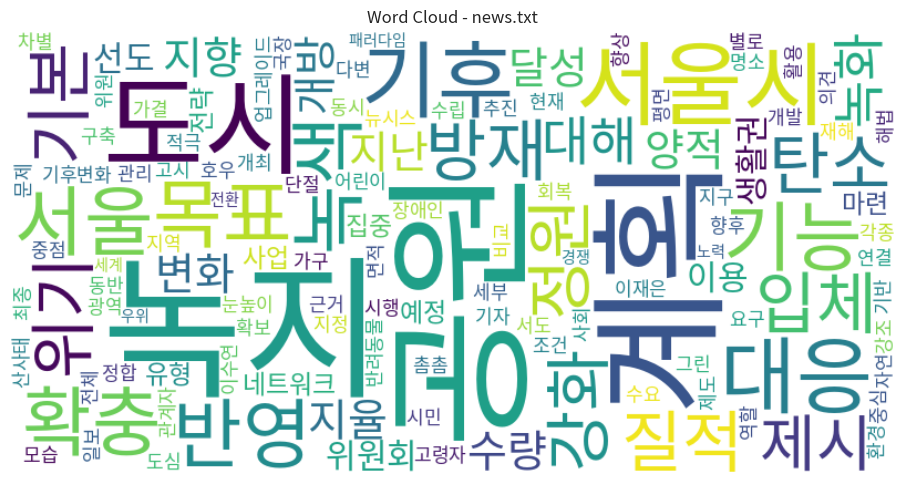

In [ ]:
# 한글 렌더링이 가능한 폰트를 찾고, 막대그래프와 워드클라우드를 그립니다.
font_candidates = [
    Path("C:/Windows/Fonts/malgun.ttf"), # Windows
    Path("/System/Library/Fonts/AppleGothic.ttf"), # macOS
    Path("/usr/share/fonts/truetype/nanum/NanumGothic.ttf"), # Ubuntu
    Path("/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"), # Ubuntu
    Path("/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc"), # Ubuntu
    Path("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"), # Ubuntu
]

font_path = None
for candidate in font_candidates:
    if candidate.exists():
        font_path = candidate
        break
if font_path is None:
    raise FileNotFoundError("한글 렌더링이 가능한 폰트를 찾지 못했습니다. font_candidates 목록을 확인하세요.")

font_manager.fontManager.addfont(str(font_path))
font_name = font_manager.FontProperties(fname=str(font_path)).get_name()

sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = font_name
order = freq_df["word"].tolist()

plt.figure(figsize=(12, 6))
sns.barplot(data=freq_df, x="word", y="count", order=order, palette="viridis")
plt.title("상위 명사 빈도 (news.txt)")
plt.xlabel("단어")
plt.ylabel("빈도")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

wordcloud = WordCloud(
    font_path=str(font_path),
    background_color="white",
    width=800,
    height=400,
)
wordcloud = wordcloud.generate_from_frequencies(freqs)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - news.txt")
plt.tight_layout()
plt.show()
